# NVD CVSS Data
---

In [1]:
import json
import pandas as pd
import glob
import re
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('../../Data/NVD/nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd = pd.DataFrame(row_accumulator)
nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);


## CVSS Graph

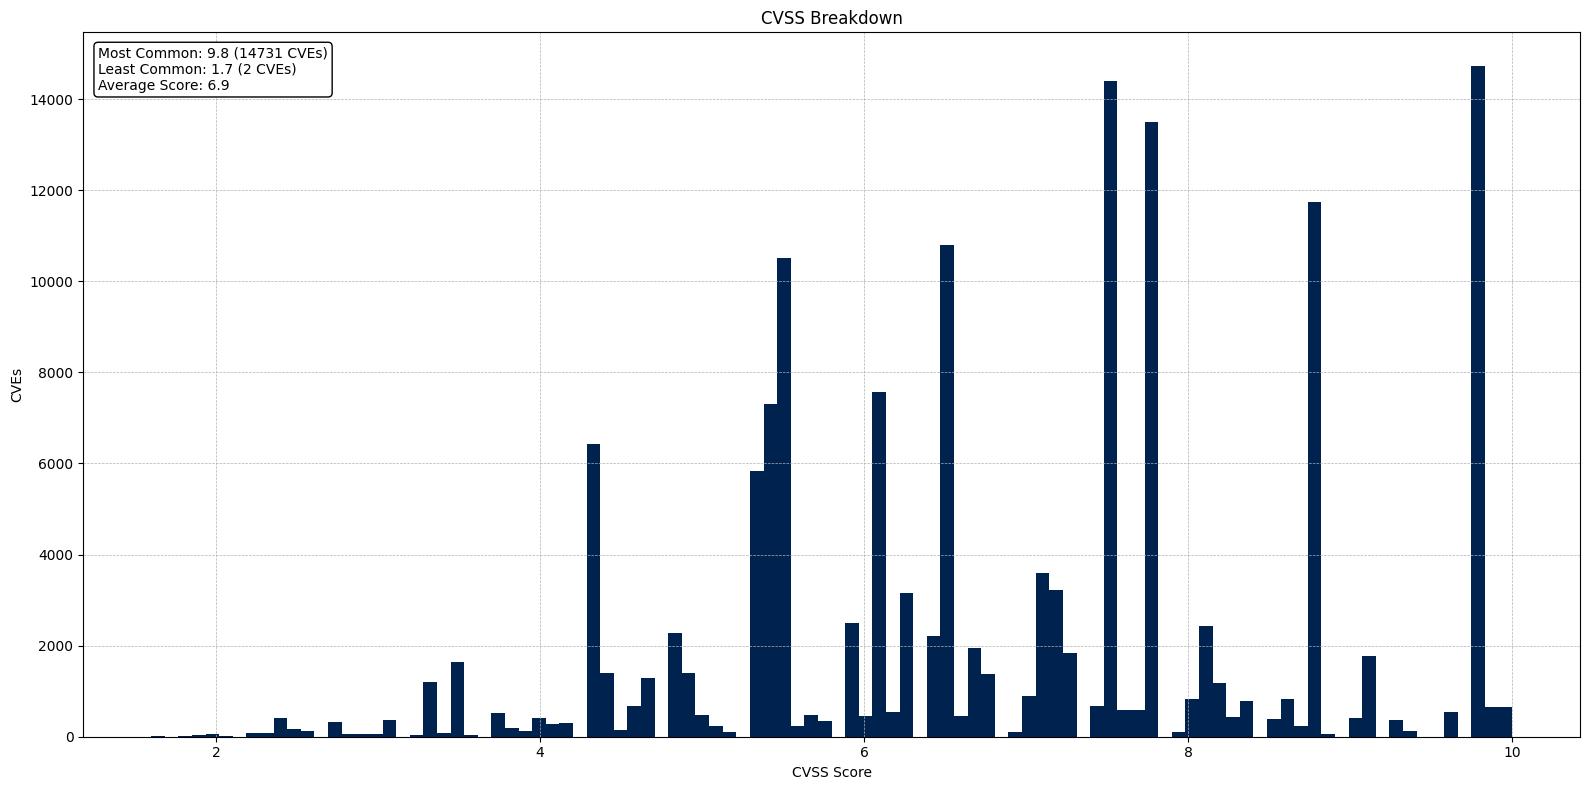

In [3]:

nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore'])
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan)

# Plot the CVSS breakdown with 100 bins
cg = nvd['BaseScore'].plot(kind="hist", bins=100, title='CVSS Breakdown', colormap='cividis', figsize=(16, 8))
plt.grid(True, linestyle='--', linewidth=0.5)
cg.set_ylabel("CVEs")
cg.set_xlabel("CVSS Score")

# Find the most common, least common, and average CVSS scores
most_common_score = nvd['BaseScore'].mode()[0]
least_common_score = nvd['BaseScore'].value_counts().idxmin()
most_common_count = nvd['BaseScore'].value_counts().max()
least_common_count = nvd['BaseScore'].value_counts().min()
average_score = nvd['BaseScore'].mean().round(2)

# Add annotation for the most common, least common, and average CVSS scores
annotation_text = (f'Most Common: {most_common_score} ({most_common_count} CVEs)\n'
                   f'Least Common: {least_common_score} ({least_common_count} CVEs)\n'
                   f'Average Score: {average_score}')
plt.text(0.01, 0.98, annotation_text, transform=cg.transAxes, fontsize=10, color='black',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Adjust layout and save the chart as a PNG file one directory up
plt.tight_layout()
plt.show()

## CVSS Count

In [4]:
# Define the bins and labels
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
labels = [str(i) for i in range(1, 11)]

# Bin the 'BaseScore' values and calculate the value counts
nvd['BaseScoreBinned'] = pd.cut(nvd['BaseScore'], bins=bins, labels=labels, right=True)
base_score_counts = nvd['BaseScoreBinned'].value_counts().sort_index()

# Reset the index and rename the columns
base_score_counts = base_score_counts.reset_index()
base_score_counts.columns = ['CVSS BaseScore (Whole Number)', 'Count']

# Display the DataFrame
base_score_counts

,CVSS BaseScore (Whole Number),Count
0,1,0
1,2,119
2,3,1379
3,4,4612
4,5,14689
5,6,28013
6,7,29052
7,8,39362
8,9,18490
9,10,18847


## Vector Count

In [5]:
# Calculate the counts of Attack Vectors
attack_vector_counts = nvd['AttackVector'].value_counts().reset_index()
attack_vector_counts.columns = ['Attack Vector', 'Count']

# Display the DataFrame
attack_vector_counts

,Attack Vector,Count
0,Missing_Data,118559
1,NETWORK,110949
2,LOCAL,37043
3,ADJACENT_NETWORK,4917
4,PHYSICAL,1670


In [6]:
# Calculate the counts of Attack Vectors as percentages
attack_vector_counts = nvd['AttackVector'].value_counts(normalize=True).mul(100).round(2).reset_index()
attack_vector_counts.columns = ['Attack Vector', 'Percentage']

# Display the DataFrame
attack_vector_counts

,Attack Vector,Percentage
0,Missing_Data,43.41
1,NETWORK,40.62
2,LOCAL,13.56
3,ADJACENT_NETWORK,1.80
4,PHYSICAL,0.61
